In [17]:
import pandas as pd
import mysql.connector
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing


##set up connection

In [18]:
# Functions that used to connect with the cloud database and display results.
def create_connection():
    conn = None
    try:
       conn = mysql.connector.connect(
          user="DB00004175",
          password="tTNlXEirHh)EmwXhtp4koTR",
          host="menu-data-db.mdb0002067.db.skysql.net",
          ssl_ca="skysql_chain.pem",
          port=5001)
       conn.autocommit = False
       return conn
    except mysql.connector.Error as e:
       print(f"Error connecting to MariaDB Platform: {e}")
    return conn

def sql_execute(conn, sql):

    try:
        cur = conn.cursor()
        cur.execute(sql, multi=True)
        conn.commit()
    except mysql.connector.Error as e:
        print(e)

def sql_execute_show(conn, sql):

    try:
        df = pd.read_sql(sql, con = conn)
        return df
    except mysql.connector.Error as e:
        print(e)

In [19]:
# Only call once
conn = create_connection()

## fetch data from database
## run clustering - an unsupervised machine learning to identify groups of restaurant based on their menu nutrient
## segment restaurant into groups with similar nutrient type
## In my opinion, it will help build our "people also like" recommendation

In [20]:
df_sql = sql_execute_show(conn, sql = '''
SELECT b.r_name, AVG(calories), AVG(total_fat), AVG(Protein), AVG(sodium), AVG(sugar), AVG(dietary_Fiber)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
GROUP BY b.r_name
;
''')

##data cleasing and normalization

In [21]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df_re = df_sql.set_index('r_name')
clean_dataset(df_re)
names = pd.DataFrame(df_re.index)


scaler = preprocessing.MinMaxScaler()
df_re_normal = scaler.fit_transform(df_re)

##clustering and find out k = 4 is the good number where the decrease in distortion starts to level off

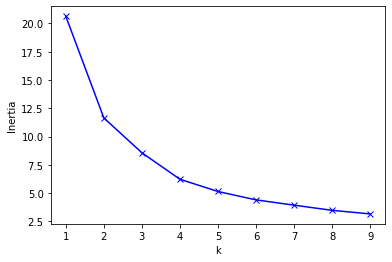

In [22]:
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_re_normal)
    kmeanModel.fit(df_re_normal)
    inertia.append(kmeanModel.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

##concate the types and restaurants together
##showing restaurants in the same group
##so that we can recommand resaurants with similiar nutrients pattern to people.

In [23]:
kmeans = KMeans(n_clusters= 4).fit(df_re_normal)
df_re.insert(0, 'Types', kmeans.labels_, True)
group0 = df_re[df_re['Types'] == 0]
print(group0)

                    Types  AVG(calories)  AVG(total_fat)  AVG(Protein)  \
r_name                                                                   
Auntie Anne's           0       275.5607          5.2865        4.4921   
Baskin Robbins          0       457.2594         18.5234        8.7413   
Burger King             0       398.2821         17.7964       11.6295   
Church's Chicken        0       249.2882          8.3869        5.9079   
Culver's                0       474.1866         30.4674       19.1938   
Dairy Queen             0       525.8934         19.7327       11.5364   
Dunkin' Donuts          0       273.7371          8.2878        6.2484   
In-N-Out Burger         0       303.7284         15.5200       11.7850   
Jamba Juice             0       299.6158          4.1945        6.8399   
KFC                     0       244.6993          7.2760        6.5721   
Krispy Kreme            0       261.4813          7.4261        6.3331   
Long John Silver's      0       215.34

In [24]:
conn.close()

